# **anaKrys**

(*version 2022.12.0*)

**notebook settings & imports  (edit %matplotlib magic here)**

In [1]:
# set %matplotlib inline (%matplotlib widget, %matplotlib qt) for static (interactive on-page, interactive in separate window) plots
# in order to use the on-page interactive mode, make sure the environment is set up properly
# comment this out before exporting the notebook to a Python script -- via jupyter nbconvert --to script anaKrys.ipynb
%matplotlib inline

# external modules
import datetime
import importlib
import os
import pickle
import succolib as sl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm

# internal modules (in .modules)
from modules import *

**starting chronometer**

In [2]:
tStart = datetime.datetime.fromtimestamp(datetime.datetime.now().timestamp())  # start chronometer
tStartPrint = tStart.strftime("%Y-%m-%d %H:%M:%S GMT")
print("%s --> let's start!" % tStartPrint)
print("--")

2023-06-18 17:47:27 GMT --> let's start!
--


---

## **input settings**

In [3]:
# data reload controller -- if True (False), reload the data files (use the dataframe already in memory)
boolLoad = True

# progressbar visualisation controller -- if True (False) the file opening progressbars will (not) be visualised
# in particular, set it to False if working in an environment with no widgets enabled
bProgressBars = False

# test mode controller: if True (False), the software runs with test (custom, selected via settingsFileMods) settings and data
boolTest = False

# run numbers or types to be opened
# format: list of strings -- insert run numbers or types as they appear in nRun0
# might be left empty in test mode -- both test runs "test0" & "test1" selected by default
nRunToOpen = ["conv_muons_front", "conv_pos1GeV_front", "conv_pos2GeV_front", "conv_pos4GeV_front"]

# label of the settings fileset to load -- useless if boolTest=False
settingsFileMods = "y23NanocalCernT9"

# filetype, string -- either "ASCII", "ROOT" or "NPZ"
fileType = "ASCII"

# file path (with / at the end), string
# useless in test mode, in which it is set automatically depending on fileType
filePath = "/eos/project/i/insulab-como/testBeam/TB_2023_06_T9_NANOCAL/MergedRoot_Mattia/ascii_merged/"

# file name format (with no path), string
# shape: replace the run number with XXXXXX and (for multiple files per run) the file number with YYYYYY
# useless in test mode, in which it is set automatically depending on fileType
fileNameFormat = "runXXXXXX_YYYYYY.dat"

#######################################
# import settings, according to boolTest and settingsFileMods
# function in .modules --> set ./settings/__init__.py for settings fileset selection
mod_runList_name, mod_settings_name = settingsSelect(boolTest, whichInput = fileType if boolTest else settingsFileMods)
globals().update(importlib.import_module(mod_runList_name).__dict__)
globals().update(importlib.import_module(mod_settings_name).__dict__)

#######################################
# print only (functions in .modules)
boolControlPrint(boolLoad, boolTest, fileType)
print("--")
settingsPrint(filePath, fileNameFormat, nRunToOpen, nRun0)  # print only (function in .modules)
print("--")

looking for files with label y23NanocalCernT9 in ./settings/
execution control booleans:
data reload controller: True
test mode controller: False
--
will work with run numbers(s)/type(s) in /eos/project/i/insulab-como/testBeam/TB_2023_06_T9_NANOCAL/MergedRoot_Mattia/ascii_merged/ with format runXXXXXX_YYYYYY.dat
(1/8) 650276 conv_muons_front
(2/8) 650285 conv_pos1GeV_front
(3/8) 650284 conv_pos2GeV_front
(4/8) 650277 conv_pos4GeV_front
(5/8) 650279 conv_pos4GeV_front
(6/8) 650281 conv_pos4GeV_front
(7/8) 650282 conv_pos4GeV_front
(8/8) 650283 conv_pos4GeV_front
--


---

## **opening the data files**

In [4]:
##############################
# data (re)loading is performed only if required
if boolLoad: 
    
    # default nRunToOpen for test mode
    if boolTest & (len(nRunToOpen)==0):
        nRunToOpen = ["test0", "test1"]  # do not edit this! proper setting above
    
    # some dataset-related info
    filePathTest = "./data_test/ascii_test/" if fileType=="ASCII" else "./data_test/tree_test/"
    fileNameFormatTest = "runXXXXXX_YYYYYY.dat" if fileType=="ASCII" else "runXXXXXX.root"
    fileNameFormatFull = (filePathTest if boolTest else filePath) + (fileNameFormatTest if boolTest else fileNameFormat)  # full filenames, i.e. with path
    nRun = {}  # dictionary of the files to be opened only (same format as nRun0)
    for iRun in nRun0:
        if (iRun in nRunToOpen) | (nRun0[iRun] in nRunToOpen):
            nRun.update({iRun: nRun0[iRun]})
    
    # data opening (function in .modules)
    # recall:
    #      - in ROOT case, remapping is also done
    #      - swapped layers are also mirrored run by run
    #      - iRun & typeRun columns also created (respectively with nRun0 keys & values)
    df, dt = loadGeneral(fileType, fileNameFormatFull, nRun, descFrac, mirrorMap, globals(), bProgressBars)
    print("--")
    
    # newly created df structure info printing
    loadDonePrint(df, dt)  # print only (function in .modules)

##############################
# print already existing df info if not (re)loading any data file
else:  
    loadSkipPrint(df)  # print only (function in .modules)
    
print("--")

opening ASCII files... --> data into DataFrame df
progressbars won't be visualized...
(1/8) 650276 -- descaling fraction: 1.000000000000


/eos/user/m/msoldani/.local/lib/python3.9/site-packages/succolib/io/ascii.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfTemp[dfTemp.index % int(1 / descFrac) == 0], ignore_index=True, sort=False)
/eos/user/m/msoldani/.local/lib/python3.9/site-packages/succolib/io/ascii.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfTemp, ignore_index=True, sort=False)


no variables to mirror
iRun also added to df
(2/8) 650277 -- descaling fraction: 1.000000000000


/eos/user/m/msoldani/.local/lib/python3.9/site-packages/succolib/io/ascii.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfTemp[dfTemp.index % int(1 / descFrac) == 0], ignore_index=True, sort=False)
/eos/user/m/msoldani/.local/lib/python3.9/site-packages/succolib/io/ascii.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfTemp, ignore_index=True, sort=False)


no variables to mirror
iRun also added to df
(3/8) 650279 -- descaling fraction: 1.000000000000


/eos/user/m/msoldani/.local/lib/python3.9/site-packages/succolib/io/ascii.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfTemp[dfTemp.index % int(1 / descFrac) == 0], ignore_index=True, sort=False)
/eos/user/m/msoldani/.local/lib/python3.9/site-packages/succolib/io/ascii.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfTemp, ignore_index=True, sort=False)


no variables to mirror
iRun also added to df
(4/8) 650281 -- descaling fraction: 1.000000000000


/eos/user/m/msoldani/.local/lib/python3.9/site-packages/succolib/io/ascii.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfTemp[dfTemp.index % int(1 / descFrac) == 0], ignore_index=True, sort=False)
/eos/user/m/msoldani/.local/lib/python3.9/site-packages/succolib/io/ascii.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfTemp, ignore_index=True, sort=False)


no variables to mirror
iRun also added to df
(5/8) 650282 -- descaling fraction: 1.000000000000


/eos/user/m/msoldani/.local/lib/python3.9/site-packages/succolib/io/ascii.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfTemp[dfTemp.index % int(1 / descFrac) == 0], ignore_index=True, sort=False)
/eos/user/m/msoldani/.local/lib/python3.9/site-packages/succolib/io/ascii.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfTemp, ignore_index=True, sort=False)


no variables to mirror
iRun also added to df
(6/8) 650283 -- descaling fraction: 1.000000000000


/eos/user/m/msoldani/.local/lib/python3.9/site-packages/succolib/io/ascii.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfTemp[dfTemp.index % int(1 / descFrac) == 0], ignore_index=True, sort=False)
/eos/user/m/msoldani/.local/lib/python3.9/site-packages/succolib/io/ascii.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfTemp, ignore_index=True, sort=False)


no variables to mirror
iRun also added to df
(7/8) 650284 -- descaling fraction: 1.000000000000


/eos/user/m/msoldani/.local/lib/python3.9/site-packages/succolib/io/ascii.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfTemp[dfTemp.index % int(1 / descFrac) == 0], ignore_index=True, sort=False)
/eos/user/m/msoldani/.local/lib/python3.9/site-packages/succolib/io/ascii.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfTemp, ignore_index=True, sort=False)


no variables to mirror
iRun also added to df
(8/8) 650285 -- descaling fraction: 1.000000000000


/eos/user/m/msoldani/.local/lib/python3.9/site-packages/succolib/io/ascii.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfTemp[dfTemp.index % int(1 / descFrac) == 0], ignore_index=True, sort=False)
/eos/user/m/msoldani/.local/lib/python3.9/site-packages/succolib/io/ascii.py:90: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfTemp, ignore_index=True, sort=False)


no variables to mirror
iRun also added to df
--
typeRun added to df
--
done (in 13.06 s) --> raw data have (events, variables) = (104599, 290)
--


In [5]:
# detect data availability (function in .modules)
# main data: 
#     iStep, epoch, xGonio (any), base xRaw/nHit (4 input, 2 output), digiPHRaw (any), digiTime (same as or less than digiPHRaw)
#     furthermore, PHCaloFwd & EFwd a priori existance is checked -- they are computed from scratch only if False
df, bIStep, bEpoch, bXGonio, bXRaw, bNHit, bDigiPHAny, lsDigiCh, bDigiTime, bPHCaloFwd0, bEFwd0 = dfCheckAvailability(df, baseTrackingMap)
print("--")

# NanoCal 2023:
bXRaw["out"] = False

# filter out the non-interesting data according to dfFilters (function in .modules)
df = dfFiltering(df, filterMap)
print("--")

# detect unavailable mandatory z entries run by run & set them to 0 (function in .modules)
z = zBaseCheckAvailability(z, df["iRun"].unique(), baseTrackingMap)
print("--")

scan step number (iStep) availability: False 
--
Unix time (epoch) availability: False 
--
goniometer DOF availability: False 
xGonioRaw + []
--
input modules should be: ['0', '1', '2', '3']
output modules should be: ['2', '3']
input tracking availability (xRaw...): True
output tracking availability (xRaw...): True
input multiplicity availability (nHit...): False
output multiplicity availability (nHit...): False
--
digitizer channel availability: True
67 channels: digiPHRaw + ['Cher0', 'Cher1', 'Crilin0', 'Crilin1', 'Crilin10', 'Crilin11', 'Crilin12', 'Crilin13', 'Crilin14', 'Crilin15', 'Crilin16', 'Crilin17', 'Crilin18', 'Crilin19', 'Crilin2', 'Crilin20', 'Crilin21', 'Crilin22', 'Crilin23', 'Crilin24', 'Crilin25', 'Crilin26', 'Crilin27', 'Crilin28', 'Crilin29', 'Crilin3', 'Crilin30', 'Crilin31', 'Crilin32', 'Crilin33', 'Crilin34', 'Crilin35', 'Crilin4', 'Crilin5', 'Crilin6', 'Crilin7', 'Crilin8', 'Crilin9', 'Empty200', 'Empty205', 'Empty206', 'Empty207', 'Empty700', 'Empty701', 'Empty

## **physics analysis**

### **input tracking**

In [6]:
# input mean multiplicity (function in .modules)
if bNHit["in"]:
    df = aveVar(df, ["nHit"+s for s in baseTrackingMap[0]], "nHitIn")
    
    # also single-hit boolean
    # note: single-hit selection is not based on nHitOut but rather on output layers individually
    df = inHitCuts(df, ["nHit"+s for s in baseTrackingMap[0]])
    
else:
    print("nHitIn & corresponding boolean not added to df")
    
print("--")

nHitIn & corresponding boolean not added to df
--


In [7]:
# input tracking (functions in .modules)
# recall that (if input positions available) input tracking is done regardless of input multiplicity
#     --> if needed, single-hit selection has to be applied manually a posteriori
if bXRaw["in"]:
    # input angles/aligned tracking info
    # also input angle selection, according to thInCut
    df = trackingAngleAlign(df, ["xRaw"+s for s in baseTrackingMap[0]], thInCentres, "thIn", z, True, thInCut)
    print("--")
    
    # input beam projection @ crystal & @ forward calorimeter
    # also crystal fiducial selection, according to xCryCut
    # also print several input beam info
    df = inputTrackingProj(df, baseTrackingMap[0], z, xCryCut)
    
else:
    print("no input beam info available --> no raw angles, aligned angles, aligned positions & projections added to df")
    
print("--")

run 650276:
thInRaw0 added to df
trying to align x layers (xRaw0 & xRaw2) with thInRaw0 mode: 0.0043333400
thInRaw1 added to df
trying to align y layers (xRaw1 & xRaw3) with thInRaw1 mode: 0.0033334000
boolInAligned: circle centered in 0 with radius 0.005000 (edge excluded)
run 650277:
thInRaw0 added to df
trying to align x layers (xRaw0 & xRaw2) with thInRaw0 mode: 0.0036666050
thInRaw1 added to df
trying to align y layers (xRaw1 & xRaw3) with thInRaw1 mode: 0.0056667150
boolInAligned: circle centered in 0 with radius 0.005000 (edge excluded)
run 650279:
thInRaw0 added to df
trying to align x layers (xRaw0 & xRaw2) with thInRaw0 mode: 0.0043332550
thInRaw1 added to df
trying to align y layers (xRaw1 & xRaw3) with thInRaw1 mode: 0.0016667700
boolInAligned: circle centered in 0 with radius 0.005000 (edge excluded)
run 650281:
thInRaw0 added to df
trying to align x layers (xRaw0 & xRaw2) with thInRaw0 mode: 0.0050000400
thInRaw1 added to df
trying to align y layers (xRaw1 & xRaw3) with t

### **goniometer**

In [8]:
# from xGonioRaw... to xGonio... -- according to info in gonioMap (function in .modules)
if bXGonio:
    df = gonioPair(df, gonioMap)
else:
    print("no goniometer info available --> no final goniometer DOF added to df")
    
print("--")

no goniometer info available --> no final goniometer DOF added to df
--


### **output tracking**

In [9]:
# output mean multiplicity (functions in .modules)
if bNHit["out"]:
    df = aveVar(df, ["nHit"+s for s in baseTrackingMap[1]], "nHitOut")
    
    # also booleans -- single-hit, low multiplicity & high-multiplicity, according to outMultCut
    # note: single-hit selection is not based on nHitOut but rather on output layers individually
    df = outHitCuts(df, ["nHit"+s for s in baseTrackingMap[1]], outMultCut)
    
else:
    print("nHitOut & corresponding booleans not added to df")
    
print("--")

nHitOut & corresponding booleans not added to df
--


In [10]:
# output tracking (functions in .modules)
# recall that (if output positions available) output tracking is done regardless of input/output multiplicity
#     --> if needed, single-hit selections have to be applied manually a posteriori
if bXRaw["out"]:
    # for output stage analysis, xCry0-1 = 0 when input tracking is absent
    if not bXRaw["in"]:
        df.loc[:, "xCry%d"%i] = 0
        print("input tracking unavailability --> doing output tracking with xCry0/1 automatically set to 0\n--")
    
    # output angles/aligned tracking info
    df = trackingAngleAlign(df, ["xCry0", "xCry1"] + ["xRaw"+s for s in baseTrackingMap[1]], thOutCentres, "thOut", z, False)
    print("--")
    
    # output-input angle delta
    df = trackingAngleDelta(df)
    
    # print output beam info
    outputTrackingPrint(df, baseTrackingMap[1])
        
else:
    print("no output beam info available --> no raw angles, aligned angles, angle deltas & aligned positions added to df")
    
print("--")

no output beam info available --> no raw angles, aligned angles, angle deltas & aligned positions added to df
--


### **digitizers**

In [11]:
# (various functions in .modules)
# recall that elements of lsDigiCh are available in df (with prefix "digiPHRaw") by definition
# if PHCaloFwd (EFwd) already in df, forward calo. sum (calibration) is not performed -- according to bPHCaloFwd0 (bEFwd0)
#     --> name the raw variable differently to (re)execute this

if (bDigiPHAny | bPHCaloFwd0 | bEFwd0):
    # channels equalisation
    df = equalise(df, lsDigiCh, equalMap)
    print("--")
    
    # PH & time booleans
    df = defineDigiBooleans(df, lsDigiCh, digiPHCut, digiTimeCut, bDigiTime)
    print("--")

    # forward calorimeter total PH
    # behaviour according to bPHCaloFwd0
    # if already existing in df, this is not performed --> name the raw variable differently to (re)execute this
    df, bPHCaloFwd = caloSum(df, bPHCaloFwd0, lsDigiChCaloFwd, "Fwd", False)
    print("--")
    
    # forward calorimeter time boolean (OR between single-channel time booleans)
    # only useful if single channels data are available (regardless of whether or not they have been used to get PHCaloFwd), otherwise always True
    df = caloTimeBool(df, bPHCaloFwd, lsDigiChCaloFwd, bDigiTime, "Fwd")
    print("--")
    
    # forward calorimeter energy in GeV
    # behaviour according to bEFwd0
    # if already existing in df, this is not performed --> name the raw variable differently to (re)execute this
    df, bEFwd = calibrate(df, bEFwd0, calibMapFwd, "Fwd", False)

else:
    bPHCaloFwd = {}
    bEFwd = {}
    print("no digitizer data available --> no equalised PH, PH & time booleans, forward calo. total PH & energy added to df")

print("--")

run 650276:
digiPH* = digiPHRaw* (all var. in lsDigiCh), i.e. not equalised (run not in equalMap)
run 650277:
digiPH* = digiPHRaw* (all var. in lsDigiCh), i.e. not equalised (run not in equalMap)
run 650279:
digiPH* = digiPHRaw* (all var. in lsDigiCh), i.e. not equalised (run not in equalMap)
run 650281:
digiPH* = digiPHRaw* (all var. in lsDigiCh), i.e. not equalised (run not in equalMap)
run 650282:
digiPH* = digiPHRaw* (all var. in lsDigiCh), i.e. not equalised (run not in equalMap)
run 650283:
digiPH* = digiPHRaw* (all var. in lsDigiCh), i.e. not equalised (run not in equalMap)
run 650284:
digiPH* = digiPHRaw* (all var. in lsDigiCh), i.e. not equalised (run not in equalMap)
run 650285:
digiPH* = digiPHRaw* (all var. in lsDigiCh), i.e. not equalised (run not in equalMap)
--
run 650276:


/eos/home-i03/m/msoldani/succo/analysis_templates/anaKrys/modules/physicsAnalysis.py:262: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[dfBool, "boolDigiPH" + iCh] = True
/eos/home-i03/m/msoldani/succo/analysis_templates/anaKrys/modules/physicsAnalysis.py:262: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[dfBool, "boolDigiPH" + iCh] = True
/eos/home-i03/m/msoldani/succo/analysis_templates/anaKrys/modules/physicsAnalysis.py:262: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calli

/eos/home-i03/m/msoldani/succo/analysis_templates/anaKrys/modules/physicsAnalysis.py:262: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[dfBool, "boolDigiPH" + iCh] = True
/eos/home-i03/m/msoldani/succo/analysis_templates/anaKrys/modules/physicsAnalysis.py:262: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[dfBool, "boolDigiPH" + iCh] = True
/eos/home-i03/m/msoldani/succo/analysis_templates/anaKrys/modules/physicsAnalysis.py:262: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calli

cuts added to df: boolDigiPH + ['Nano']


/eos/home-i03/m/msoldani/succo/analysis_templates/anaKrys/modules/physicsAnalysis.py:280: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[dfBool, "boolDigiTime" + iCh] = True
/eos/home-i03/m/msoldani/succo/analysis_templates/anaKrys/modules/physicsAnalysis.py:280: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[dfBool, "boolDigiTime" + iCh] = True
/eos/home-i03/m/msoldani/succo/analysis_templates/anaKrys/modules/physicsAnalysis.py:280: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of c

/eos/home-i03/m/msoldani/succo/analysis_templates/anaKrys/modules/physicsAnalysis.py:280: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[dfBool, "boolDigiTime" + iCh] = True
/eos/home-i03/m/msoldani/succo/analysis_templates/anaKrys/modules/physicsAnalysis.py:280: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[dfBool, "boolDigiTime" + iCh] = True


cuts added to df: boolDigiTime + ['Nano']
run 650277:
cuts added to df: boolDigiPH + ['Nano']
cuts added to df: boolDigiTime + ['Nano']
run 650279:
cuts added to df: boolDigiPH + ['Nano']
cuts added to df: boolDigiTime + ['Nano']
run 650281:
cuts added to df: boolDigiPH + ['Nano']
cuts added to df: boolDigiTime + ['Nano']
run 650282:
cuts added to df: boolDigiPH + ['Nano']
cuts added to df: boolDigiTime + ['Nano']
run 650283:
cuts added to df: boolDigiPH + ['Nano']
cuts added to df: boolDigiTime + ['Nano']
run 650284:
cuts added to df: boolDigiPH + ['Nano']
cuts added to df: boolDigiTime + ['Nano']
run 650285:
cuts added to df: boolDigiPH + ['Nano']
cuts added to df: boolDigiTime + ['Nano']
--
run 650276:
PHCaloFwd not already in df --> can be created
PHCaloFwd added to df
run 650277:
PHCaloFwd not already in df --> can be created
PHCaloFwd added to df
run 650279:
PHCaloFwd not already in df --> can be created
PHCaloFwd added to df
run 650281:
PHCaloFwd not already in df --> can be cre

/eos/home-i03/m/msoldani/succo/analysis_templates/anaKrys/modules/physicsAnalysis.py:316: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[dfBool, "PHCalo"+caloName] = sum([df["digiPH" + s] for s in lsDigiChCalo[iRun]])
/eos/home-i03/m/msoldani/succo/analysis_templates/anaKrys/modules/physicsAnalysis.py:349: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[dfBool, "boolTimeCalo"+caloName] = False


run 650279:
1 time entries found in df for CaloFwd channels --> boolTimeCaloFwd added to df (OR between channels)
run 650281:
1 time entries found in df for CaloFwd channels --> boolTimeCaloFwd added to df (OR between channels)
run 650282:
1 time entries found in df for CaloFwd channels --> boolTimeCaloFwd added to df (OR between channels)
run 650283:
1 time entries found in df for CaloFwd channels --> boolTimeCaloFwd added to df (OR between channels)
run 650284:
1 time entries found in df for CaloFwd channels --> boolTimeCaloFwd added to df (OR between channels)
run 650285:
1 time entries found in df for CaloFwd channels --> boolTimeCaloFwd added to df (OR between channels)
--
run 650276:
EFwd not already in df --> can be created
EFwd not added to df (calib. function not defined for this run)
run 650277:
EFwd not already in df --> can be created
EFwd not added to df (calib. function not defined for this run)
run 650279:
EFwd not already in df --> can be created
EFwd not added to df (c

---

## **plots & output**

In [12]:
# initialising output plots data dictionary -- empty, it will be filled with the objects needed
outData = {}

# initialising units of measurement dictionary -- empty string for all the df variables by default
units = dict(zip(df.columns, ["" for s in df.columns]))

# limiting the selection dictionaries to the runs currently under study
thInCut0 = {k: v for k, v in thInCut.items() if k in df["iRun"].unique()}
xCryCut0 = {k: v for k, v in xCryCut.items() if k in df["iRun"].unique()}
outMultCut0 = {k: v for k, v in outMultCut.items() if k in df["iRun"].unique()}
digiPHCut0 = {k: v for k, v in digiPHCut.items() if k in df["iRun"].unique()}
digiTimeCut0 = {k: v for k, v in digiTimeCut.items() if k in df["iRun"].unique()}

### **plot & output settings (other settings in each plot cell)**

In [13]:
# if True (False), base plots and related fits are (not) created
boolPlotGlob = True

# units -- dictionary of the units of measurement for plots
# shape: {var: unit} (all string)
# unit format: unit between brackets
# all the missing variable units are automatically set to empty strings (above)
units.update({"epoch": "[s]"})
units.update({"EFwd": "[GeV]"})
units.update({"x"+baseTrackingMap[0][0]: "[cm]"})
units.update({"x"+baseTrackingMap[0][1]: "[cm]"})
units.update({"xCry0": "[cm]"})
units.update({"xCry1": "[cm]"})
for iCh in [s for s in df.columns if "digiPH" in s]:
    units.update({iCh: "[ADC]"})
for iCh in [s for s in df.columns if "digiTime" in s]:
    units.update({iCh: "[ADC]"})
for iTh in [s for s in df.columns if ("thIn" in s) | ("thOut" in s)]:
    units.update({iTh: "[rad]"})

# other graphic settings
pal2d = "viridis"  # palette for 2d plots
lineC = "0.7"  # color of plot patches (e.g. selection ranges) lines
fitC = "0.1" # color of fit lines
lineW = 1.5  # width of plot patches (e.g. selection ranges) lines
fitW = 1.5  # width of fit lines

# if True (False), figures are (not) saved in ./out_plots
# this is particularly important when running the software as a Python script
bPlotSave = True

# also recall to set boolPlotGlob above, in the input settings section

### **run base info**

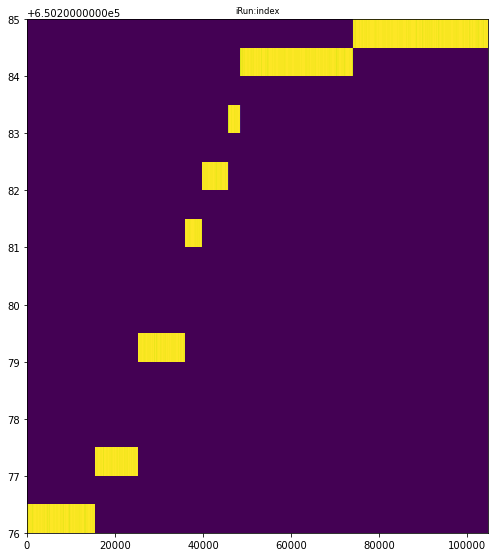

In [14]:
boolPlotLoc = True  # figure(s) here only drawn if True
figName = "runInfo"  # figure name
xSize = 7  # horizontal figure size
ySize = 8  # vertical figure size
bUseEpoch = False  # if True (False) the epoch (automatic event index) is used -- only if epoch in df, otherwise event index anyway

###############
if boolPlotLoc & boolPlotGlob:
    ax = plot_runInfo(df, ["boolSingleHitIn"] if bNHit["in"] else [], bXGonio, bEpoch, bUseEpoch, pal2d, units, xSize, ySize, figName, bPlotSave)
    # if input multiplicity is available, base info are studied in input single hit condition
    # this is always drawn, since at least iRun is always created inside df -- goniometer DOF availability checked inside the function

### TRACKING **input beam profiles & spot**

In [15]:
boolPlotLoc = False  # figure(s) here only drawn if True
figName = "xIn"  # figure name -- the part "_1d"/"_2d" will be appended
xSize = [7, 3]  # horizontal figure size -- 1d-then-2d
ySize = [3, 3]  # vertical figure size -- 1d-then-2d
binSize = [0.01, 0.01]  # bin size, same for x & y in all the plots below -- 1d-then-2d -- if a component is None, it is automatically computed
hRange = [[0, 2], [0, 2]]  # axes ranges, same in all the plots below -- format [[x0, x1] or None, [y0, y1] or None] (if None, automatic definition)
bLog = False  # if True (False), log (lin) scale on z
bPlot2d = True  # if True (False), 2d profile plot is (not) plotted
lsBool = ["boolSingleHitIn"]  # list of booleans (available in df) to be applied to all the plots here

###############
if boolPlotLoc & boolPlotGlob & bXRaw["in"]:
    outData = plot_prof(df, ("x"+baseTrackingMap[0][0], "x"+baseTrackingMap[0][1]), binSize[0], lsBool, hRange, outData, bLog, units, xSize[0], ySize[0], figName+"1d", bPlotSave)
    if bPlot2d:
        plot_proj(df, ("x"+baseTrackingMap[0][0], "x"+baseTrackingMap[0][1]), binSize[1], lsBool, hRange, False, {}, bLog, lineC, lineW, pal2d, units, xSize[1], ySize[1], figName+"2d", bPlotSave)

# outData is updated with bin-by-bin spectra values & fit parameters -- entries "thIn/OutN_histo/fit"

### TRACKING **angles**

spectrum returned in a dictionary with key thIn0_histo -- x, y, ey
performing gaussian fit on thIn0...
fit parameters:
	ampl.	5.619751e+03 +- 2.832877e+04
	mean	-5.667372e-04 +- 6.579996e-09
	sigma	3.437487e-03 +- 4.611857e-09
fit parameters are returned in a dictionary with key thIn0 -- parameters, cov. matrix_fit
--
spectrum returned in a dictionary with key thIn1_histo -- x, y, ey
performing gaussian fit on thIn1...
fit parameters:
	ampl.	4.071442e+03 +- 1.674618e+03
	mean	1.620300e-04 +- 1.793365e-09
	sigma	4.904289e-03 +- 1.644175e-09
fit parameters are returned in a dictionary with key thIn1 -- parameters, cov. matrix_fit
--


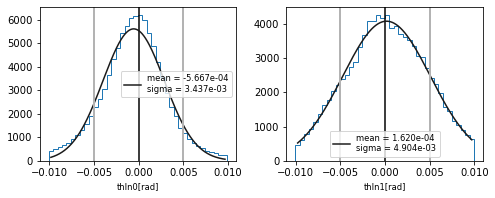

In [16]:
boolPlotLoc = True  # figure(s) here only drawn if True
figName = ["thIn", "thOut", "thDelta"]  # figure names -- in-then-out-then-delta
xSize = 7  # horizontal figure size
ySize = 3  # vertical figure size
xRange = [[-0.01, 0.01], [-0.01, 0.01], [-0.01, 0.01]]  # plot ranges, in-then-out-then-delta -- for each, left-then-right, same for x & y -- values can be None (i.e. automatic definition)
binSize = [0.0005, 0.0005, 0.0005]  # bin sizes -- in-then-out-then-delta -- if a value is None, automatically computed
bFit = [True, False, False]  # do fits if True -- in-then-out-then-delta
fitSigma = [0.0001, 0.0001, 0.0001]  # starting point for sigma fits (set to ~ half the distribution FWHM or None, i.e. automatic computation) -- in-then-out-then-delta, only used if bFit=True
bSel = True  # draw input selection according to thInCut -- only for input
bLog = False  # if True (False), log (lin) scale on y

###############
lsBool = [[], [], []]
if bNHit["in"]:
    lsBool[0].append("boolSingleHitIn")
    lsBool[1].append("boolSingleHitIn")
    lsBool[2].append("boolSingleHitIn")
if bNHit["out"]:
    lsBool[1].append("boolSingleHitOut")
    lsBool[2].append("boolSingleHitOut")
# if input/input-output multiplicity is available, input/output & delta angle distr. are studied in input/input-output single hit condition

if boolPlotLoc & boolPlotGlob:
    if bXRaw["in"]:
        outData = plot_th(df, "thIn", binSize[0], lsBool[0], xRange[0], bFit[0], fitSigma[0], outData, bSel, thInCut0, bLog, fitC, fitW, lineC, lineW, units, xSize, ySize, figName[0], bPlotSave)
    if bXRaw["out"]:
        # recall that output angles are computed even in absence of input tracking data -- hits @ crystal automatically set to (0, 0, 0)
        outData = plot_th(df, "thOut", binSize[1], lsBool[1], xRange[1], bFit[1], fitSigma[1], outData, False, {}, bLog, fitC, fitW, lineC, lineW, units, xSize, ySize, figName[1], bPlotSave)
    if bXRaw["in"] & bXRaw["out"]:
        outData = plot_th(df, "thDelta", binSize[2], lsBool[2], xRange[2], bFit[2], fitSigma[2], outData, False, {}, bLog, fitC, fitW, lineC, lineW, units, xSize, ySize, figName[2], bPlotSave)
        
# outData is updated with bin-by-bin spectra values & fit parameters -- entries "thIn/OutN_histo/fit"

### TRACKING **multiplicities**

In [17]:
boolPlotLoc = False  # figure(s) here only drawn if True
figName = "nHitOut"  # figure name
xSize = 7  # horizontal figure size
ySize = 4  # vertical figure size
bUseEpoch = False  # if True (False) the epoch (automatic event index) is used -- only if epoch in df, otherwise event index anyway
maxNHit = 10  # multiplicity upper limit -- if None, range (& binning) automatically defined
bSel = True  # draw output selection according to outMultCut -- only for output
tRange = None  # range on the 2d plots x to be used to costrain the data included in the 1d plots -- length-2 array or None (for no costraint)
bLog = False  # if True (False), log (lin) scale on y/z in 1d/2d plots

###############
if boolPlotLoc & boolPlotGlob & bNHit["out"]:
    outData = plot_nHit(df, "nHitOut", ["boolSingleHitIn"] if bNHit["in"] else [], bEpoch, bUseEpoch, maxNHit, tRange, bSel, outMultCut0, outData, bLog, lineC, lineW, pal2d, units, xSize, ySize, figName, bPlotSave)
    # if input multiplicity is available, output multiplicity is studied in input single hit condition
    
# outData is updated with bin-by-bin spectra values (2d & 1d) -- entries "nHitOut_nameX_histo" (2d) & "nHitOut_iRun_histo" (1d)

### TRACKING **beam spots @ crystal**

In [18]:
boolPlotLoc = False  # figure(s) here only drawn if True
figName = "xCry"  # figure name
xSize = 3  # horizontal figure size
ySize = 3  # vertical figure size
binSize = 0.01  # bin size, same for x & y in all the plots below -- if None, automatically computed
hRange = [[0.5, 2.0], [0.0, 1.5]]  # axes ranges, same in all the plots below -- format [[x0, x1] or None, [y0, y1] or None] (if None, automatic definition)
bSel = [True, True]  # draw fiducial selection according to xCryCut -- plot without multiplicity cut, then plots with multiplicity cut
bLog = False  # if True (False), log (lin) scale on z

###############
lsBool0 = ["boolSingleHitIn"] if bNHit["in"] else []
# if input multiplicity is available, beam projections @ crystal are studied in input single hit condition

if boolPlotLoc & boolPlotGlob & bXRaw["in"]:
    plot_proj(df, "xCry", binSize, lsBool0+[], hRange, bSel[0], xCryCut0, bLog, lineC, lineW, pal2d, units, xSize, ySize, figName, bPlotSave)
    if bNHit["out"]:
        # furthermore, study with different output multiplicity selection performed only if output multiplicity data available
        plot_proj(df, "xCry", binSize, lsBool0+["boolLowHitOut"], hRange, bSel[1], xCryCut0, bLog, lineC, lineW, pal2d, units, xSize, ySize, "xCry_lowHitOut", bPlotSave)
        plot_proj(df, "xCry", binSize, lsBool0+["boolHighHitOut"], hRange, bSel[1], xCryCut0, bLog, lineC, lineW, pal2d, units, xSize, ySize, "xCry_highHitOut", bPlotSave)

### GONIOMETER **2d phase space**

In [19]:
boolPlotLoc = False  # figure(s) here only drawn if True
figName = "gonioPhaseSpace"  # figure name
xSize = 4  # horizontal figure size
ySize = 4  # vertical figure size
lsVar = ["Rot", "Crad"]  # length-2 list of gonio. variables to be plot (x-then-y) -- names without the prefix xGonio
lsBool = ["boolInCry"]  # list of booleans (available in df) to be applied -- input single hit condition applied automatically (if data available)
bLog = False  # if True (False), log (lin) scale on z

###############
lsBool0 = ["boolSingleHitIn"] if bNHit["in"] else []
# if input multiplicity is available, goniometer DOF phase space is studied in input single hit condition

if boolPlotLoc & boolPlotGlob & bXGonio:
    plot_gonioCorr(df, lsVar, lsBool0+lsBool, bLog, pal2d, units, xSize, ySize, figName, bPlotSave)

### GONIOMETER **trends over other variables**

In [20]:
boolPlotLoc = False  # figure(s) here only drawn if True
figName = "gonioTrends"  # figure name base -- it will be completed with "_" and the name of each variable under study
xSize = 7  # horizontal figure size (for each single figures)
ySize = 4  # vertical figure size (for each single figures)
lsBool = ["boolInAligned", "boolInCry"]  # list of booleans (available in df) to be applied to all the plots here -- input single hit cond. applied automatically (if data available)
bLog = False  # if True (False), log (lin) scale on z

# dictionary of the variables to be analysed -- shape:
# {varY (string): {
#         varX0 (string): [[xL0, xR0, dx0], [yL0, yR0, dy0], [bDrawProf0 (bool), bFit0 (bool), deg0 (integer), xFitL0, xFitR0]], (float if not otherwise specified)
#         varX1: [[xL1, xR1, dx1], [yL1, yR1, dy1], [bDrawProf1, bFit1, deg1, xFitL1, xFitR1]],
#         ...
# }}
# 1 figure per varY, each with 1 plot per varX -- varX format: part of the variable name following "xGonioRaw"
# plot in ranges (xL, xR) & (yL, yR) with bin size dx & dy
# profile plot polynomial fit with degree deg -- supported deg = 0, 1, 2; also Gaussian fit if deg = "Gaussian"
# all entries (apart from bFit) can also be None -- automatic definition in this case (e.g. deg = 0)
dictGonioTrends = {
    "nHitOut": {
        "Rot": [[None, None, None], [None, None, 1], [True, True, 2, None, None]],
    },
}
        
###############
lsBool0 = ["boolSingleHitIn"] if bNHit["in"] else []
# if input multiplicity is available, goniometer trends are studied in input single hit condition

if boolPlotLoc & boolPlotGlob & bXGonio:
    for i, iY in enumerate(dictGonioTrends):
        outData = plot_gonioTrends(df, iY, dictGonioTrends[iY], lsBool0+lsBool, outData, bLog, fitC, fitW, lineC, lineW, pal2d, units, xSize, ySize, figName, bPlotSave)
        
# outData is updated with profile plots & fit info (only if fit requested) -- entries name format: "nameY_nameX_prof" & "nameY_nameX_fit"

### DIGITIZERS **single-channel PH-vs-time phase spaces**

In [21]:
boolPlotLoc = False  # figure(s) here only drawn if True
figName = "digi"  # figure name
xSize = 7  # horizontal figure size
ySize = 8  # vertical figure size
lsBool = []  # list of booleans (available in df) to be applied -- same for all the channels (if using cuts on crystal, consider including input single hit cond.)
binSize = [8, 4]  # bin sizes -- time-then-PH -- if a value is None, automatically computed
bSel = True  # draw PH & time selection boxes according to digiPHCut & digiTimeCut -- same boolean for all the digitizer channels
bLog = True  # if True (False), log (lin) scale on z

###############
if boolPlotLoc & boolPlotGlob & bDigiPHAny:
    plot_digi(df, lsDigiCh, binSize, lsBool, bDigiTime, bSel, digiPHCut0, digiTimeCut0, bLog, lineC, lineW, pal2d, units, xSize, ySize, figName, bPlotSave)

### DIGITIZERS **forward calorimeter energy**

In [22]:
boolPlotLoc = False  # figure(s) here only drawn if True
figName = "energyFwd"  # figure name
xSize = 7  # horizontal figure size
ySize = 5  # vertical figure size
binSize = 2  # bin size - can't be set to None (needed for errorbars)
xRange = None  # plot range - [min, max] or None (for automatic definition for each typeRun value separately)
lsBool = ["boolSingleHitIn", "boolInAligned", "boolInCry", "boolTimeCaloFwd"]  # list of booleans (available in df) to be applied -- selection on typeRun applied automatically (if using cuts on crystal, consider including input single hit cond.)
bUseEpoch = False  # if True (False) the epoch (automatic event index) is used -- only if epoch in df, otherwise event index anyway
bLog = False  # if True (False), log (lin) scale on y/z in 1d/2d plots

###############
if boolPlotLoc & boolPlotGlob & any(bEFwd.values()):
    outData = plot_energyRuns(df, "Fwd", binSize, bEFwd, xRange, bEpoch, bUseEpoch, lsBool, bLog, outData, pal2d, units, xSize, ySize, figName, bPlotSave)  # forward calo. energy
    
# outData is updated with bin-by-bin spectra values -- entries name format: "EFwd_typeRun_histo"

---

### **output data**

In [23]:
# output dictionary outData saved as in ./out_data/outData.pickle
globals().update(outData)
saveOutData(globals())  # function in .modules
print("--")

########
# to open the Pickle file importing the anaKrys modules: 
#    outData = readOutData()  # function in .modules

saving output dictionary outData to ./out_data/outData.pickle, with 4 entries
--


---

## **whiteboard**

In [24]:
# colour map
cmap_name = "viridis"
cmap = plt.get_cmap(cmap_name).copy()
cmap.set_bad('white')

In [25]:
# new variables
df["xCrilin0"] = sl.zProj(df["x2"], 72.6, df["x0"], 0, 72.6+241.5)
df["xCrilin1"] = sl.zProj(df["x3"], 72.6, df["x1"], 0, 72.6+241.5)

df["digiTimeNanoCorr"] = df.digiTimeNano - df.digiTimeTrigD + df.digiTimeTrigD.mean()

df["digiTimeTrigACorr"] = df.digiTimeTrigA - df.digiTimeTrigD + df.digiTimeTrigD.mean()
df["digiTimeTrigBCorr"] = df.digiTimeTrigB - df.digiTimeTrigD + df.digiTimeTrigD.mean()
df["digiTimeTrigCCorr"] = df.digiTimeTrigC - df.digiTimeTrigD + df.digiTimeTrigD.mean()
df["digiTimeTrigDCorr"] = df.digiTimeTrigD - df.digiTimeTrigD + df.digiTimeTrigD.mean()
df["digiTimeTrigECorr"] = df.digiTimeTrigE - df.digiTimeTrigD + df.digiTimeTrigD.mean()

for run in df.iRun.unique():
    print(run, digiTimeCut[run])
    df.loc[df.iRun==run, "boolDigiTimeNanoCorr"] =\
        ((df.digiTimeNanoCorr) > digiTimeCut[run]["Nano"][0]) &\
        ((df.digiTimeNanoCorr) < digiTimeCut[run]["Nano"][1])

650276 {'Nano': [180, 280]}
650277 {'Nano': [180, 280]}
650279 {'Nano': [180, 280]}
650281 {'Nano': [180, 280]}
650282 {'Nano': [180, 280]}
650283 {'Nano': [180, 280]}
650284 {'Nano': [180, 280]}
650285 {'Nano': [180, 280]}


/tmp/ipykernel_2635/2118877724.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["xCrilin0"] = sl.zProj(df["x2"], 72.6, df["x0"], 0, 72.6+241.5)
/tmp/ipykernel_2635/2118877724.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["xCrilin1"] = sl.zProj(df["x3"], 72.6, df["x1"], 0, 72.6+241.5)
/tmp/ipykernel_2635/2118877724.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conc

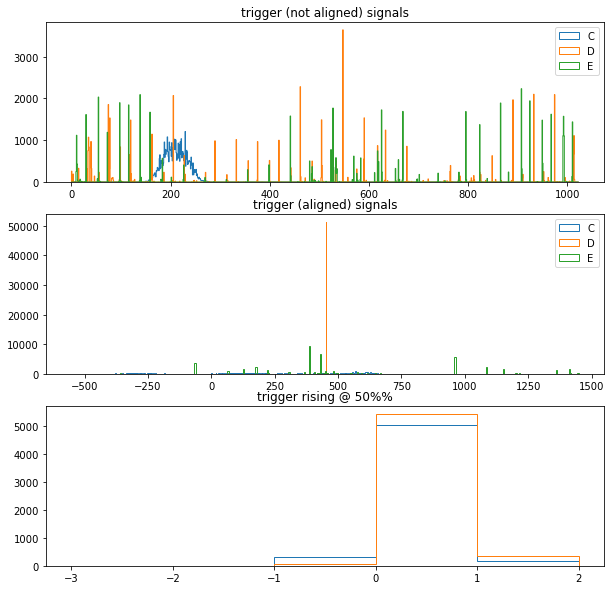

In [26]:
# scintillators, times
plt.figure(figsize=(10, 10))
if True:
    plt.subplot(311)
    #plt.hist(df[df.boolInAligned].digiTimeTrigA, bins=np.arange(0, 1024, 1), histtype="step", label="A") ;
    #plt.hist(df[df.boolInAligned].digiTimeTrigB, bins=np.arange(0, 1024, 1), histtype="step", label="B") ;
    plt.hist(df[df.boolInAligned].digiTimeTrigC, bins=np.arange(0, 1024, 1), histtype="step", label="C") ;
    plt.hist(df[df.boolInAligned].digiTimeTrigD, bins=np.arange(0, 1024, 1), histtype="step", label="D") ;
    plt.hist(df[df.boolInAligned].digiTimeTrigE, bins=np.arange(0, 1024, 1), histtype="step", label="E") ;
    plt.yscale("linear")
    plt.title("trigger (not aligned) signals")
    plt.legend()
    
    plt.subplot(312)
    #plt.hist(df[df.boolInAligned].digiTimeTrigACorr, bins=400, histtype="step", label="A") ;
    #plt.hist(df[df.boolInAligned].digiTimeTrigBCorr, bins=400, histtype="step", label="B") ;
    plt.hist(df[df.boolInAligned].digiTimeTrigCCorr, bins=400, histtype="step", label="C") ;
    plt.hist(df[df.boolInAligned].digiTimeTrigDCorr, bins=400, histtype="step", label="D") ;
    plt.hist(df[df.boolInAligned].digiTimeTrigECorr, bins=400, histtype="step", label="E") ;
    plt.yscale("linear")
    plt.title("trigger (aligned) signals")
    plt.legend()

    plt.subplot(313)
    #plt.hist(df[df.boolInAligned].digiPHEmpty7200, bins=400, histtype="step") ;
    ##plt.hist(df[df.boolInAligned & (df.digiPHRawLucite0>38) & (df.digiPHRawLucite1>38)].digiHalfTime7420, bins=400, histtype="step", color="C1") ;
    ##plt.hist(df[df.boolInAligned & (df.digiPHRawLucite0>38) & (df.digiPHRawLucite1>38)].digiHalfTime7423, bins=400, histtype="step", color="C2") ;
    ##plt.hist(df[df.boolInAligned & (df.digiPHRawLucite0>38) & (df.digiPHRawLucite1>38)].digiHalfTime7426, bins=400, histtype="step", color="C3") ;
    plt.hist(df[df.boolInAligned & (df.digiPHRawLucite0>38) & (df.digiPHRawLucite1>38)].digiTimeLucite1 - df[df.boolInAligned & (df.digiPHRawLucite0>38) & (df.digiPHRawLucite1>38)].digiTimeLucite0, bins=np.arange(-3, 3, 1), histtype="step") ;
    plt.hist(df[df.boolInAligned & (df.digiPHRawLucite0>38) & (df.digiPHRawLucite1>38)].digiHalfTime7427 - df[df.boolInAligned & (df.digiPHRawLucite0>38) & (df.digiPHRawLucite1>38)].digiHalfTime7426, bins=np.arange(-3, 3, 1), histtype="step") ;
    #plt.xlim((-10, 10))
    #plt.hist(df[df.boolInAligned].digiTimeTrigB-df[df.boolInAligned].digiTimeTrigC+df[df.boolInAligned].digiTimeTrigC.mean(), bins=400, histtype="step", color="k") ;
    plt.yscale("linear")
    plt.title("trigger rising @ 50%%")

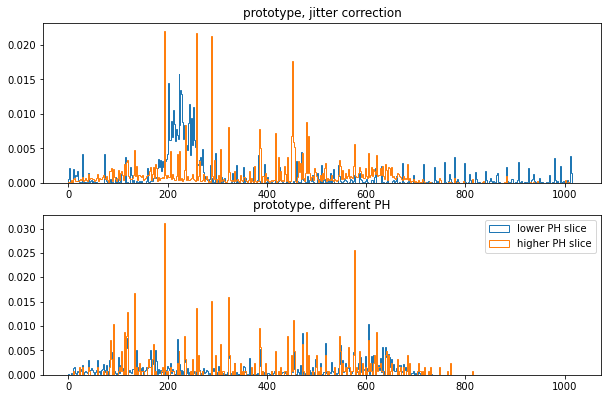

In [27]:
# prototype times analysis - NanoCal
if True:
    plt.figure(figsize=(10, 10))

    plt.subplot(311)
    plt.hist(
        df[df.boolInAligned].digiTimeNano,
        bins=np.arange(0, 1024, 2), histtype="step", density=True
    ) ;
    plt.hist(
        df[df.boolInAligned].digiTimeNanoCorr, 
        bins=np.arange(0, 1024, 2), histtype="step", density=True
    ) ;
    plt.yscale("linear")
    plt.title("prototype, jitter correction")
    
    plt.subplot(312)
    plt.hist(
        df[df.boolInAligned & ((df.digiPHNano>100) & (df.digiPHNano<800))].digiTimeNanoCorr,
        bins=np.arange(0, 1024, 2), histtype="step", density=True, label="lower PH slice"
    ) ;
    plt.hist(
        df[df.boolInAligned & ((df.digiPHNano>30) & (df.digiPHNano<60))].digiTimeNanoCorr, 
        bins=np.arange(0, 1024, 2), histtype="step", density=True, label="higher PH slice"
    ) ;
    plt.yscale("linear")
    plt.title("prototype, different PH")
    plt.legend()

conv_muons_front 11895
conv_pos4GeV_front 19263
conv_pos2GeV_front 11493
conv_pos1GeV_front 8702


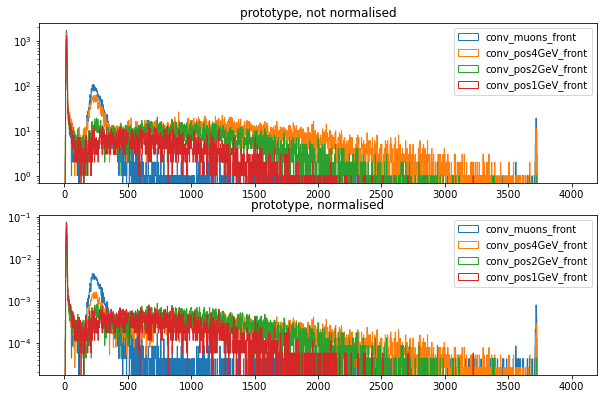

In [47]:
# calorimeter PHs - NanoCal
if True:
    plt.figure(figsize=(10, 10))
    plt.subplot(311)
    lim = 4000
    
    for run in df.typeRun.unique():
        print(run, df[(df.typeRun==run) & df.boolInAligned].shape[0])
        
        var = "digiPHEmpty200" if (run=="pvt_muons_front") else "digiPHNano"
        
        plt.subplot(311)
        plt.hist(df[(df.typeRun==run) & df.boolInAligned][var], bins=np.arange(0, lim, 2), histtype="step", label=run) ;
        plt.yscale("log")
        plt.title("prototype, not normalised")
        plt.legend()
        
        plt.subplot(312)
        plt.hist(df[(df.typeRun==run) & df.boolInAligned][var], bins=np.arange(0, lim, 2), histtype="step", label=run, density=True) ;
        plt.yscale("log")
        plt.title("prototype, normalised")
        plt.legend()

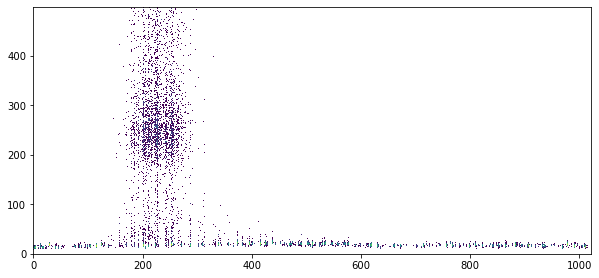

In [29]:
# calorimeter digitizer phase space - NanoCal
if True:
    lim = 500
    
    plt.figure(figsize=(10, 10))
    plt.subplot(211)
    x = df[df.boolInAligned].digiTimeNano
    y = df[df.boolInAligned].digiPHRawNano
    plt.hist2d(x, y, bins=(np.arange(0, 1023, 1), np.arange(0, lim, 1)), norm=LogNorm()) ;

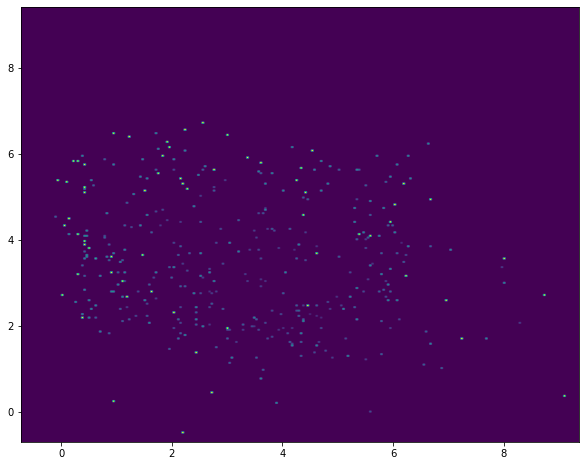

In [30]:
# calorimeter efficiency map - NanoCal
bContourf = False
bLog = False
bins = 250

if True:
    plt.figure(figsize=(10, 8))
    x, y = "xCaloFwd0", "xCaloFwd1"
    dftempD = df[df.boolInAligned][[x, y]]
    dftempN = df[
        df.boolInAligned &\
        ((df.digiPHNano>80) & (df.digiPHNano<200)) &\
        ((df.digiTimeNano>250) & (df.digiTimeNano<400)) 
    ][[x, y]]

    if bContourf:
        countsN, ybins, xbins = np.histogram2d(dftempN[x], dftempN[y], bins=bins)
        countsN[countsN==0]=np.nan
        countsD, ybins, xbins = np.histogram2d(dftempD[x], dftempD[y], bins=bins)
        countsD[countsD==0]=np.nan
        plt.contourf(countsN.T/countsD.T, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], levels=200, norm=LogNorm() if bLog else None)
    else:
        _ = sl.hist2dRatio(dftempN[x], dftempN[y], dftempD[x], dftempD[y], bins=bins, cmap=cmap, norm=LogNorm() if bLog else None)

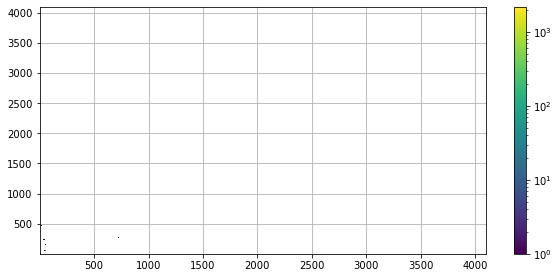

In [31]:
# correlation between signals in Lucite/Cindy
if True:
    bXYLog = False
    
    plt.figure(figsize=(10, 10))
    plt.subplot(211)
    plt.hist2d(df[df.boolInAligned].digiPHRawLucite0, df[df.boolInAligned].digiPHRawLucite1, bins=np.arange(1, 4100, 1), norm=LogNorm()) ;
    plt.colorbar()
    plt.grid(True)
    if bXYLog:
        plt.xscale("log")
        plt.yscale("log")

In [32]:
# CRILIN single-layer spectra
if False:
    lim = 2000
    bFid = (df.xCrilin0>2.8) & (df.xCrilin0<3.8) & (df.xCrilin1>4.8) & (df.xCrilin1<5.8)
    bXYLog = True
    
    plt.figure(figsize=(10, 10))
    plt.subplot(211)
    plt.hist(df[df.boolInAligned & bFid]["digiPHCrilinTot0"], bins=np.arange(0, lim, 10), histtype="step", density=True, label="layer 0");
    plt.hist(df[df.boolInAligned & bFid]["digiPHCrilinTot1"], bins=np.arange(0, lim, 10), histtype="step", density=True, label="layer 1");
    plt.yscale("log")
    
    plt.subplot(212)
    plt.hist2d(
        df[df.boolInAligned & bFid].digiPHRawLucite0, 
        df[df.boolInAligned & bFid].digiPHRawLucite1, 
        bins=np.arange(1, lim, 1), norm=LogNorm()
    ) ;
    plt.colorbar()
    plt.grid(True)
    if bXYLog:
        plt.xscale("log")
        plt.yscale("log")

In [33]:
#plt.figure()
#x = df[df.boolInAligned & (df.digiPHRawLucite1>38)].digiTimeLucite0 # -\
#        #df[df.boolInAligned & (df.digiPHRawLucite1>38)].digiTimeTrigC +\
#        #df[df.boolInAligned & (df.digiPHRawLucite1>38)].digiTimeTrigC.mean() 
#y = df[df.boolInAligned & (df.digiPHRawLucite1>38)].digiPHRawLucite0
#plt.hist2d(x, y, bins=(100, np.arange(0, 70, 1)), norm=LogNorm()) ;

In [34]:
#plt.figure()
#
#plt.subplot(211)
#for ch in [s for s in df.columns if "PHRawCrilin" in s]:
#    plt.hist(df[df.boolInAligned][ch], bins=np.arange(0, 100, 3), histtype="step", density=True);
#plt.yscale("log")
#    
#plt.subplot(212)
#ls0, ls1 = [], []
#for ch in [s for s in df.columns if "digiPHRawCrilin" in s]:
#    i = int(ch.replace("digiPHRawCrilin", ""))
#    if i<18:
#        ls0.append(ch)
#    else:
#        ls1.append(ch)
#df["digiPHCrilinTot0"] = df[ls0].sum(axis=1)
#df["digiPHCrilinTot1"] = df[ls1].sum(axis=1)
#plt.hist(df[df.boolInAligned]["digiPHCrilinTot0"], bins=np.arange(0, 2000, 10), histtype="step", density=True);
#plt.hist(df[df.boolInAligned]["digiPHCrilinTot1"], bins=np.arange(0, 2000, 10), histtype="step", density=True);
#plt.yscale("log")

In [35]:
## calorimeter efficiency map - CRILIN
#bContourf = False
#bLog = False
#bins = 200
#
#plt.hist2d(df.digiPHCrilinTot0, df.digiPHCrilinTot1, bins=100, norm=LogNorm()) ;

In [36]:
#plt.figure()
#for ch in [s for s in df.columns if "digiTimeCrilin" in s]:
#    plt.subplot(211)
#    plt.hist(df[df.boolInAligned][ch], bins=np.arange(10, 1024, 30), histtype="step")
#    plt.subplot(212)
#    plt.hist(df[df.boolInAligned & (df[ch.replace("Time", "PHRaw")]>40)][ch], bins=np.arange(10, 1024, 30), histtype="step", density=False)

In [37]:
## calorimeter efficiency map - CRILIN
#bContourf = False
#bLog = False
#bins = 200
#
#df["xCrilin0"] = sl.zProj(df["x2"], 72.6, df["x0"], 0, 72.6+241.5)
#df["xCrilin1"] = sl.zProj(df["x3"], 72.6, df["x1"], 0, 72.6+241.5)
#
#if True:
#    plt.figure(figsize=(10, 10))
#    x, y = "xCrilin0", "xCrilin1"
#    dftempD = df[df.boolInAligned][[x, y]]
#    dftempN = df[
#        df.boolInAligned & (((df.digiPHCrilinTot0+df.digiPHCrilinTot1)>400)) &\
#        ((df.digiTimeCrilin10>240) & (df.digiTimeCrilin10<340)) &\
#        ((df.digiTimeCrilin11>240) & (df.digiTimeCrilin11<340))
#    ][[x, y]]
#
#    if bContourf:
#        countsN, ybins, xbins = np.histogram2d(dftempN[x], dftempN[y], bins=bins)
#        countsN[counts==0]=np.nan
#        countsD, ybins, xbins = np.histogram2d(dftempD[x], dftempD[y], bins=bins)
#        countsD[counts==0]=np.nan
#        plt.contourf(countsN.T/countsD.T, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], levels=20, norm=LogNorm() if bLog else None)
#    else:
#        a = sl.hist2dRatio(dftempN[x], dftempN[y], dftempD[x], dftempD[y], bins=bins, cmap=cmap, norm=LogNorm() if bLog else None)

In [38]:
## calorimeter efficiency map - CRILIN
#bContourf = False
#bLog = False
#bins = 200
#
#plt.figure()
#
#plt.subplot(121)
#
#bBool =df.boolInAligned & \
#    ((df.digiPHCrilinTot0>1200) & (df.digiPHCrilinTot0<1400)) & ((df.digiPHCrilinTot1>200) & (df.digiPHCrilinTot1<400))
#
#plt.hist2d(df[bBool]["xCrilin0"], df[bBool]["xCrilin1"], bins=bins, cmap=cmap, norm=LogNorm() if bLog else None) ;
#
#plt.subplot(122)
#
#bBool =df.boolInAligned & \
#    ((df.digiPHCrilinTot0>200) & (df.digiPHCrilinTot0<400)) & ((df.digiPHCrilinTot1>800) & (df.digiPHCrilinTot1<1000))
#
#plt.hist2d(df[bBool]["xCrilin0"], df[bBool]["xCrilin1"], bins=bins, cmap=cmap, norm=LogNorm() if bLog else None) ;

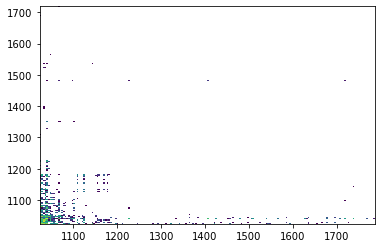

In [39]:
plt.figure()
plt.hist2d(df.digiHalfTime7424, df.digiHalfTime7425, bins=200, norm=LogNorm()) ;

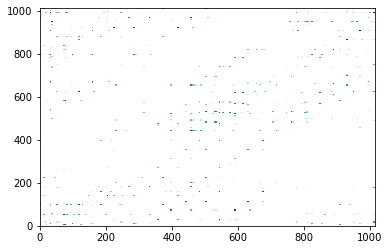

In [40]:
plt.figure()
plt.hist2d(df.digiTimeTrigD, df.digiTimeTrigE, bins=200, norm=LogNorm(), cmap="Blues") ;

---

**stopping chronometer**

In [41]:
tStop = datetime.datetime.fromtimestamp(datetime.datetime.now().timestamp())  # stop chronometer
tStopPrint = tStop.strftime("%Y-%m-%d %H:%M:%S GMT")
dt = tStop - tStart
dtPrint = str(dt - datetime.timedelta(microseconds=dt.microseconds))
print("stop @ %s" % tStopPrint)
print("total elapsed time (from last restart -- %s): %s" % (tStartPrint, dtPrint))
outData["execTime"] = [tStart, tStop, dt]
print("execution time info added to outData[""execTime""] -- start, stop, delta\n--")

stop @ 2023-06-18 17:53:33 GMT
total elapsed time (from last restart -- 2023-06-18 17:47:27 GMT): 0:06:05
execution time info added to outData[execTime] -- start, stop, delta
--


**(re)writing output data**

In [42]:
# this is done to add the execTime entry, together with any other entry from the whiteboard
globals().update(outData)
saveOutData(globals())  # function in .modules
print("--")

########
# to open the Pickle file importing the anaKrys modules: 
#    outData = readOutData()  # function in .modules

saving output dictionary outData to ./out_data/outData.pickle, with 5 entries
--
